In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
## Generate Guassian Input
x = tf.random.normal((1, 100), mean = 0, stddev=1)
print(tf.reduce_mean(x).numpy(), tf.math.reduce_std(x).numpy())

## 1. In Activations
* We shall check what conditions lead to vanishing and exploding activations 
* Assume simple linear network of layers without activations

* output = $w_n * w_{n-1} * .... * w_0 * x $
* If network, n being large - output will
    * vanish if w < 1
    * explode if w > 1
    * because we are multiplying repeatedly same number n times. So the elements in w becomes $w^n$.

### 1. 1 Exploding Activations

In [ ]:
## Frwd Prop : Assuming 100 layer NN
## You would find it quickly goes to nan (explodes)
for i in range(100):
    w = tf.random.normal((100, 100))
    x = tf.matmul(x, w)
print(tf.reduce_mean(x), tf.math.reduce_std(x))

In [ ]:
## Checking at which layer, the mean goes to nan
x = tf.random.normal((1, 100), mean = 0, stddev=1)
for i in range(100):
    w = tf.random.normal((100, 100), mean = 0, stddev=1)  # changing stddev alter when network explodes
    x = tf.matmul(x, w)
    if tf.math.is_nan(tf.reduce_mean(x).numpy()):
        print(i)
        break

Observations
* The activation outputs exploded within 37 of our network’s layers. 
* High stddev -> higher chance of mean exploding -> implying high weights multipled togther -> quick exploding
* In other words, we have initialized our weights large

### 1.2 Vanishing Activations

In [ ]:
## Scaling weights and checking the output
x = tf.random.normal((1, 100), mean = 0, stddev=1)
for i in range(100):
    w = tf.random.normal((100, 100), mean = 0, stddev=1)*0.05
    x = tf.matmul(x, w)
print(tf.reduce_mean(x).numpy(), tf.math.reduce_std(x).numpy())

Observations
* If we scale the weights by lower number, the activations get vanished to zero
* **Summary** : If weights are initialized too large, the network won’t learn well. The same happens when weights are initialized too small.

# 2. In Gradients
* Consider a neural network with sigmoid activations
* We know the derivative of sigmoid is predominantly zero and has max value of 0.25 at x = 0 
* Consider gradient of loss wrt w
$$ \frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial A_3} * \frac{\partial A_3}{\partial A_2} * \frac{\partial A_2}{\partial A_1} * \frac{\partial A_1}{\partial w_1} $$
where,
$ A_3 = \sigma(z_3) $
* Exploding Gradients: if in  above equation, the terms are > 1
* Vanishing Gradients: if in  above equation, the terms are < 1

### 2.1 Exploding Gradients

* Take one of the terms $\frac{\partial A_3}{\partial A_2}$,

$$ \frac{\partial A_3}{\partial A_2} =  \frac{\partial A_3}{\partial z_3} * \frac{\partial z_3}{\partial A_2}$$
$$  =  \sigma(z3)*(1 - \sigma(z3)) * \frac{\partial (w_2*A_2 + b_2)}{\partial A_2}$$
$$ \frac{\partial A_3}{\partial A_2} =  \sigma^{'}(z3)* w_2$$

* The above term can be > 1, if w is large (like 100) despite $ \sigma^{'}(z) \in [0, 0.25] $. 

* Now when we multiply such terms with initial weight matrix being large -> we will have exploding gradient


### 2.2 Vanishing Gradients
* In the same situation, when w is < 1 and we are multiplying large number of gradient of sigmoid which is very low

* Leading to vanishing gradient

## 3. Validation
### 3.1 Validating Multiple Initializations
* Zero
* Uniform
* Normal
* He Uniform
* He Normal
* Glorot Uniform
* Glorot Normal

In [61]:
from sklearn.datasets import load_iris
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.set_floatx('float32')

<AxesSubplot:>

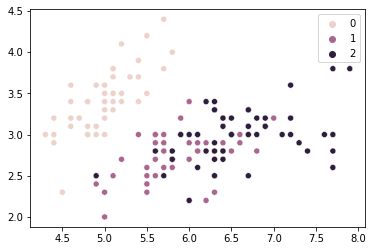

In [62]:
load_iris = load_iris()
X, y = load_iris['data'], load_iris['target']
# y = tf.cast()
sns.scatterplot(X[:,0], X[:, 1], hue = y)

In [63]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 42)

num_inputs = 4
xtrain = tf.reshape(xtrain, (-1, num_inputs))
xtrain = tf.cast(xtrain, tf.float32)
xtest = tf.reshape(xtest, (-1, num_inputs))
xtest = tf.cast(xtest, tf.float32)

In [190]:
def load_data(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size = 100)
    return dataset.batch(batch_size)

In [197]:
init_list = {'zero':tf.keras.initializers.zeros(), 'rand_normal' : tf.keras.initializers.RandomNormal(), 'rand_uniform' : tf.keras.initializers.RandomUniform(), 'he_normal' : tf.keras.initializers.he_normal(), 'he_uniform' : tf.keras.initializers.he_uniform(), 'glorot_normal' : tf.keras.initializers.GlorotNormal(), 'glorot_uniform' : tf.keras.initializers.GlorotUniform()}

In [198]:
training_loss_combined, training_accuracy_combined = [], []

for init_name, init_type in zip(init_list.keys(), init_list.values()):
    print(init_name)
    
    tf.keras.backend.clear_session()
    num_epoch, lr, batch_size = 201, 0.05, 32
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    data_iter = load_data((xtrain, ytrain), batch_size)
    
    tf_clf = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, kernel_initializer=init_type, input_dim = 4), 
    tf.keras.layers.Dense(10, activation=tf.nn.relu, kernel_initializer=init_type),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ])

    data_iter = load_data((xtrain, ytrain), batch_size)
    training_loss, training_accuracy = [], []
    for epoch in range(num_epoch):
        for X, y in data_iter:
            with tf.GradientTape() as tape:
                yhat = tf_clf(X, training = True)
                epoch_loss = loss(y, yhat)
                
            # Gradient
            params = tf_clf.trainable_variables
            grads = tape.gradient(epoch_loss, params)

            # Update Gradient
            optimizer.apply_gradients(zip(grads, params))
        
        epoch_loss = loss(ytrain, tf_clf(xtrain)).numpy()
        epoch_accuracy = accuracy(ytrain, tf_clf(xtrain)).numpy()
        training_loss.append(epoch_loss)
        training_accuracy.append(epoch_accuracy)
    
    training_loss_combined.append(training_loss)
    training_accuracy_combined.append(training_accuracy)

zero
rand_normal
rand_uniform
he_normal
he_uniform
glorot_normal
glorot_uniform


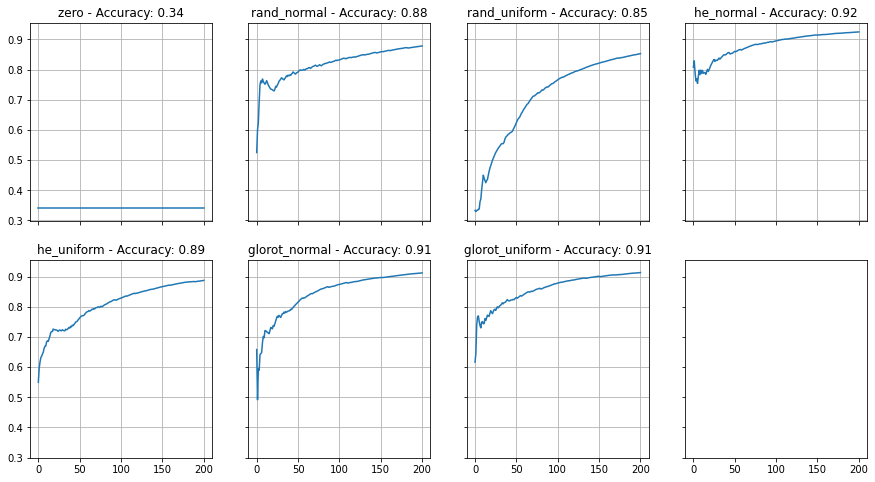

In [245]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(num_epoch), training_accuracy_combined[:num_epoch][i])
    ax.grid()
    title =  list(init_list.keys())[i] + ' - Accuracy: ' + str(np.round(training_accuracy_combined[:num_epoch][i][-1], 2))
    ax.set_title(title)
    if i == len(init_list)-1:
        break
plt.show()

## 3.2 Validating Vanishing Gradients : Random Normal Initialization

In [313]:
tf.keras.backend.clear_session()
num_epoch, lr, batch_size = 201, 0.05, 32

loss = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
data_iter = load_data((xtrain, ytrain), batch_size)

init_type = tf.keras.initializers.RandomNormal(mean=0, stddev=0.500)

tf_clf = tf.keras.Sequential([
tf.keras.layers.Dense(2, activation=tf.nn.sigmoid, kernel_initializer=init_type, input_dim = 4), 
# tf.keras.layers.Dense(2, activation=tf.nn.sigmoid, kernel_initializer=init_type),
# tf.keras.layers.Dense(2, activation=tf.nn.sigmoid, kernel_initializer=init_type),
# tf.keras.layers.Dense(2, activation=tf.nn.sigmoid, kernel_initializer=init_type),
# tf.keras.layers.Dense(2, activation=tf.nn.sigmoid, kernel_initializer=init_type),
tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

data_iter = load_data((xtrain, ytrain), batch_size)
training_loss, training_accuracy = [], []
for epoch in range(num_epoch):
    for X, y in data_iter:
        with tf.GradientTape() as tape:
            yhat = tf_clf(X, training = True)
            epoch_loss = loss(y, yhat)
            
        # Gradient
        params = tf_clf.trainable_variables
        grads = tape.gradient(epoch_loss, params)
        
        # Update Gradient
        optimizer.apply_gradients(zip(grads, params))
    
    if epoch == 0:
        print(params[0].numpy())
        print(grads[0].numpy())
    
    if epoch % 20 == 0:
        print(tf.reduce_mean(grads[0]).numpy())
    
    epoch_loss = loss(ytrain, tf_clf(xtrain)).numpy()
    epoch_accuracy = accuracy(ytrain, tf_clf(xtrain)).numpy()
    training_loss.append(epoch_loss)
    training_accuracy.append(epoch_accuracy)

[[ 1.0738577   0.77064764]
 [-0.32786447  0.05012571]
 [-0.4492269  -0.15706818]
 [-0.5743941  -0.45341805]]
[[-0.01705577  0.00543181]
 [-0.0028261  -0.00076863]
 [-0.02532454  0.01265956]
 [-0.01010856  0.00536811]]
-0.004078014
0.008519675
0.025805179
-0.022998618
0.010158591
-0.0036928204
0.0045355917
-0.0053217686
0.0019810698
-0.008956033
0.011094194


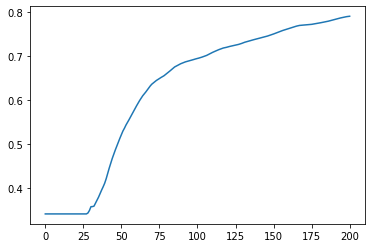

In [314]:
plt.plot(np.arange(num_epoch), training_accuracy)

In [287]:
tf.reduce_mean(grads[2].numpy())

<tf.Tensor: id=6679897, shape=(), dtype=float32, numpy=-3.188906e-07>